#Import libraries

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
from tensorflow.python.keras.preprocessing import image as kp_image
import time
import functools

In [ ]:
def load_img(path_to_img):

  max_dim = 512

  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels = 3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title = None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis = 0)

  plt.imshow(image)
  if title is not None:
    plt.title(title)

In [ ]:
def gram_matrix(input_tensor):

  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)

  input_shape = tf.shape(input_tensor)

  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  
  return result/(num_locations)

In [ ]:
from google.colab import drive


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Paths to content and style images

<font color="red"> Change these paths!</font>

In [ ]:
#content_path = '/content/drive/MyDrive/Cher Eng Lim - images.zip (Unzipped Files)/images/content_green_sea_turtle.jpeg'
#style_path = '/content/drive/MyDrive/Cher Eng Lim - images.zip (Unzipped Files)/images/style_great_wave_off_Kanagawa.jpeg'

#content_path = '/content/drive/MyDrive/Cher Eng Lim - images.zip (Unzipped Files)/images/content_darth_2.jpg'
#style_path = '/content/drive/MyDrive/Cher Eng Lim - images.zip (Unzipped Files)/images/style_mosaic.jpg'

content_path = '/content/drive/MyDrive/Cher Eng Lim - images.zip (Unzipped Files)/images/content_landscape.jpg'
style_path = '/content/drive/MyDrive/Cher Eng Lim - images.zip (Unzipped Files)/images/style_Van Gogh_landscape.jpg'

content_path = '/content/drive/MyDrive/Cher Eng Lim - images.zip (Unzipped Files)/images/content_Tuebingen_Neckarfront.jpg'
style_path = '/content/drive/MyDrive/Cher Eng Lim - images.zip (Unzipped Files)/images/style_Van Gogh_starry night.jpg'

content_path = '/content/drive/MyDrive/Cher Eng Lim - images.zip (Unzipped Files)/images/content_green_sea_turtle.jpeg'
style_path = '/content/drive/MyDrive/Cher Eng Lim - images.zip (Unzipped Files)/images/style_great_wave_off_Kanagawa.jpeg'

content_path = '/content/drive/MyDrive/Cher Eng Lim - images.zip (Unzipped Files)/images/content_darth_2.jpg'
style_path = '/content/drive/MyDrive/Cher Eng Lim - images.zip (Unzipped Files)/images/style_mosaic.jpg'


#Visualize the content and style images

##Load two images:

- `content_image`

- `style_image`

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

## Display the two images

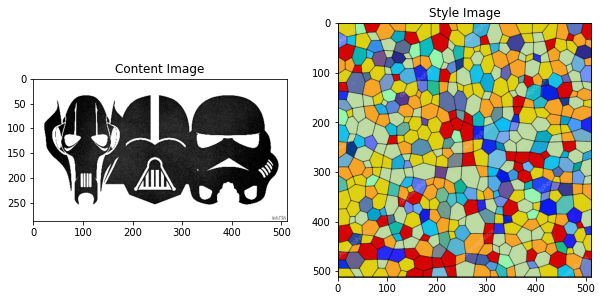

In [ ]:
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

#Set the intermediate layers in VGG model for content and style

In [ ]:
# Content layer 
content_layers = ['block5_conv2'] 

# Style layers
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
num_content_layers

1

In [ ]:
num_style_layers

5

#Build your model

In [ ]:
def get_model():

  # Load VGG9 model without the top part
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')

  # We freeze the whole VGG19
  vgg.trainable = False
  
  # Let's have an emply list
  # Name: style_ouputs 
  style_outputs = []

  # Have a for-loop here to scan through all elements of content_layers
  # For each element, append 'vgg.get_layer(....).output' to 
  # 'style_outputs'
  style_outputs = []
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  
  # Let's have an emply list
  # Name: content_ouputs 
  content_outputs = []

  # Have a for-loop here to scan through all elements of content_layers
  # For each element, append 'vgg.get_layer(....).output' to 
  # 'content_outputs'
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  #....................................................
  

  # Use '+' to join 'style_outputs' and 'content_outputs'
  outputs = style_outputs + content_outputs

  # Build your model by using
  # tf.keras.Model(...., ....)
  # First input: [vgg.input]
  # Second input: outputs

  model = tf.keras.Model([vgg.input], outputs)

  return model

#Define a function to extract style and content from the model. Define the loss function

In [ ]:
def get_style_content(model, inputs):

  # Don't remove this line
  inputs = inputs*255
  
  # Use: tf.keras.applications.vgg19.preprocess_input(input)
  # to transform your input into a suitable format for your model
  preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
  
  # Pass it through the model
  outputs = model(preprocessed_input)

  # style_outputs: outputs[:num_style_layers]
  # content_outputs: the rest ot outputs
  style_outputs, content_outputs = outputs[:num_style_layers], outputs[num_style_layers:]

  # Convert 'style_outputs' to Gram matrices
  # Use a for-loop and gram_matrix() function to
  # scan through style_outputs
  style_outputs_Gram = [gram_matrix(style_output) for style_output in style_outputs]
  

  # From a dictionary: style_dict 
  style_dict = {style_name: value
                for style_name, value
                in zip(style_layers, style_outputs_Gram)}

  # From a dictionary: content_dict
  content_dict = {content_name:value
                  for content_name, value
                  in zip(content_layers, content_outputs)}

  return {'content':content_dict, 'style':style_dict}


In [ ]:
def style_content_loss(outputs):

    style_outputs = outputs['style']

    content_outputs = outputs['content']

    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss

    return loss

# Pass the style and content images through the model.
- Style Image --> Model --> Style Targets
- Content Image --> Model --> Content Targets

Use `get_model()` to create `my_model`.

In [ ]:
my_model = get_model()

Pass the two images through your model to get `style_targets` and `content_targets`.

<font color="red">These two variables are calculated only once. They are used in style_content_loss() to calculate the loss.</font>

In [ ]:
style_targets = get_style_content(my_model, style_image)['style']
content_targets = get_style_content(my_model, content_image)['content']

#Main programme

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

## `step` function

In [ ]:
def step_function(image):
  with tf.GradientTape() as tape:

    # Call get_style_content() to get the the content and style 
    # (combined in outputs)
    outputs = get_style_content(my_model, image)

    # Use 'ouputs' and call style_content_loss() to have the loss
    loss = style_content_loss(outputs)

  # Differentiate the loss w.r.t to 'image'
  grad = tape.gradient(loss, image)

  # Update 'image'
  opt.apply_gradients([(grad, image)])

  # Need to clip the result
  # to avoid exploded values
  image.assign(clip_0_1(image))

## Optimizer:

In [114]:
opt = tf.optimizers.Adam(learning_rate=0.01, beta_1=0.99, epsilon=1e-1)

## style_weight and content_weight

In [115]:
style_weight = 1.0
content_weight = 1e2

## Training loop

In [116]:
image = tf.Variable(content_image)

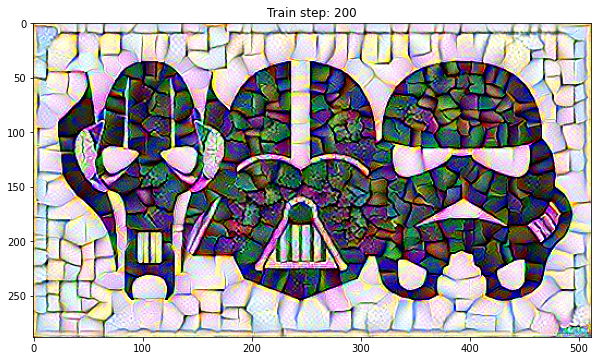

Total time: 23.6


In [117]:
import time
start = time.time()

epochs = 20
steps_per_epoch = 10

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1

    # call step_function
    step_function(image)

    print(".", end='')

  display.clear_output(wait = True)
  imshow(image.read_value(), "Train step: {}".format(step))

  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))